# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

/opt/homebrew/Caskroom/miniforge/base/envs/mnist-proj/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/mnist-proj/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/homebrew/Caskroom/miniforge/base/envs/mnist-proj/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/mnist-proj/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/mnist-proj/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/mnist-proj/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/mnist-proj/bin/../lib/libjpeg.9.dylib' (no such file

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [78]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.), (1.))
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST('../', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST('../', train=False, transform=transform, download=True)

# Create test set and define test dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**Answer:** The transforms consists of two processes: turning the image to tensor and normalising the values of the tensor. The first one is important for the further normalisation preprocessing. The normalisation is important to keep the values small and around 0 for good training result.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [79]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


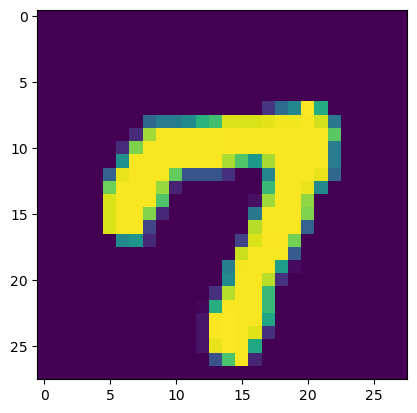

1


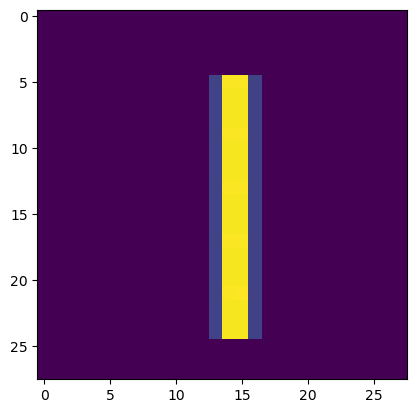

3


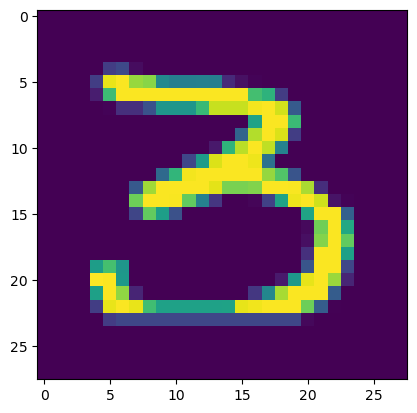

7


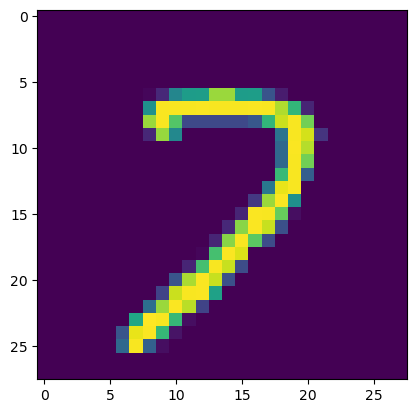

8


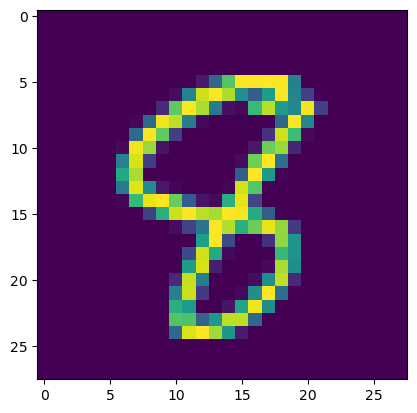

In [80]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [127]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.do = nn.Dropout()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.do(x)
        x = self.activation(self.fc2(x))
        x = self.do(x)
        x = self.fc3(x)

        return x

model = Model()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [128]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [40]:
device = 'mps' if torch.mps.is_available() else 'cpu' # set device to mps if using Apple silicon (local environment)

In [129]:
model = model.to(device)

In [130]:
# Keep loss history for plotting
train_loss_history = list()
test_loss_history = list()
train_acc_history = list()
test_acc_history = list()

# Start training
print("Training start\n===============")
for epoch in range(10):
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i, data in enumerate(train_loader):
        model.train() # turn on gradient tracking
        
        # Load inputs and labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradient
        optimiser.zero_grad()

        # Get outputs and their errors
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Compute gradient and backpropagate
        loss.backward()
        optimiser.step()

        # Compute the accuracy and print the accuracy and loss
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs.data, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    # Print status and save loss & accuracy
    train_acc = (train_correct/train_total) * 100
    train_loss_mean = train_loss/len(train_loader)
    print(f'Epoch {epoch + 1} training accuracy: {train_acc:.2f}% training loss: {train_loss_mean:.5f}')
    train_loss_history.append(train_loss_mean)
    train_acc_history.append(train_acc)

    # Start testing step
    test_loss = 0
    test_correct = 0
    test_total = 0
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs.data, 1)
            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()
            test_loss += loss.item()

    # Print status and save loss & accuracy 
    test_acc = (test_correct/test_total) * 100
    test_loss_mean = test_loss/len(test_loader)
    print(f'Epoch {epoch + 1} validation accuracy: {test_acc:.2f}% validation loss: {test_loss_mean:.5f}')
    test_loss_history.append(test_loss_mean)
    test_acc_history.append(test_acc)

Training start
Epoch 1 training accuracy: 73.70% training loss: 0.82143
Epoch 1 validation accuracy: 91.71% validation loss: 0.29652
Epoch 2 training accuracy: 84.61% training loss: 0.52563
Epoch 2 validation accuracy: 93.28% validation loss: 0.23310
Epoch 3 training accuracy: 86.34% training loss: 0.46438
Epoch 3 validation accuracy: 94.34% validation loss: 0.20135
Epoch 4 training accuracy: 87.35% training loss: 0.43600
Epoch 4 validation accuracy: 94.55% validation loss: 0.19257
Epoch 5 training accuracy: 88.11% training loss: 0.40984
Epoch 5 validation accuracy: 94.79% validation loss: 0.18197
Epoch 6 training accuracy: 88.49% training loss: 0.39702
Epoch 6 validation accuracy: 94.92% validation loss: 0.18543
Epoch 7 training accuracy: 88.68% training loss: 0.38587
Epoch 7 validation accuracy: 95.35% validation loss: 0.17328
Epoch 8 training accuracy: 88.92% training loss: 0.38001
Epoch 8 validation accuracy: 95.39% validation loss: 0.17030
Epoch 9 training accuracy: 89.12% trainin

Plot the training loss (and validation loss/accuracy, if recorded).

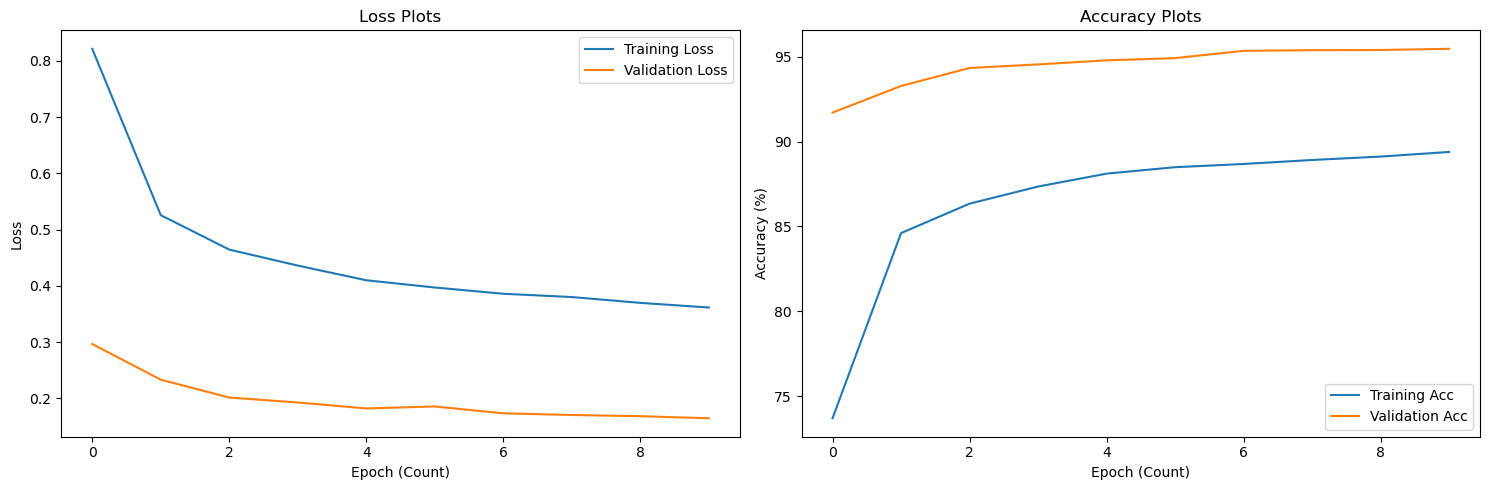

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_loss_history, label='Training Loss')
axs[0].plot(test_loss_history, label='Validation Loss')
axs[0].set_title('Loss Plots')
axs[0].set_xlabel('Epoch (Count)')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(train_acc_history, label='Training Acc')
axs[1].plot(test_acc_history, label='Validation Acc')
axs[1].set_title('Accuracy Plots')
axs[1].set_xlabel('Epoch (Count)')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
plt.tight_layout()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##
## Testing is done in every epoch as shown above, achieving > 95% validation accuracy

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [132]:
model2 = Model()
model2 = model2.to(device)

Changing learning rate: 0.001 => 0.01

In [134]:
criterion2 = nn.CrossEntropyLoss()
optimiser2 = optim.Adam(model2.parameters(), lr=0.01)

In [135]:
# Keep loss history for plotting
train_loss_history = list()
test_loss_history = list()
train_acc_history = list()
test_acc_history = list()

# Start training
print("Training start\n===============")
for epoch in range(10):
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i, data in enumerate(train_loader):
        model2.train() # turn on gradient tracking
        
        # Load inputs and labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradient
        optimiser2.zero_grad()

        # Get outputs and their errors
        outputs = model2(inputs)
        loss = criterion2(outputs, labels)

        # Compute gradient and backpropagate
        loss.backward()
        optimiser2.step()

        # Compute the accuracy and print the accuracy and loss
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs.data, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    # Print status and save loss & accuracy
    train_acc = (train_correct/train_total) * 100
    train_loss_mean = train_loss/len(train_loader)
    print(f'Epoch {epoch + 1} training accuracy: {train_acc:.2f}% training loss: {train_loss_mean:.5f}')
    train_loss_history.append(train_loss_mean)
    train_acc_history.append(train_acc)

    # Start testing step
    test_loss = 0
    test_correct = 0
    test_total = 0
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            outputs = model2(inputs)
            loss = criterion2(outputs, labels)
            
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs.data, 1)
            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()
            test_loss += loss.item()

    # Print status and save loss & accuracy 
    test_acc = (test_correct/test_total) * 100
    test_loss_mean = test_loss/len(test_loader)
    print(f'Epoch {epoch + 1} validation accuracy: {test_acc:.2f}% validation loss: {test_loss_mean:.5f}')
    test_loss_history.append(test_loss_mean)
    test_acc_history.append(test_acc)

Training start
Epoch 1 training accuracy: 73.44% training loss: 0.86471
Epoch 1 validation accuracy: 76.76% validation loss: 0.78916
Epoch 2 training accuracy: 78.78% training loss: 0.72815
Epoch 2 validation accuracy: 79.49% validation loss: 0.78638
Epoch 3 training accuracy: 79.12% training loss: 0.71593
Epoch 3 validation accuracy: 79.86% validation loss: 0.68877
Epoch 4 training accuracy: 79.44% training loss: 0.69799
Epoch 4 validation accuracy: 79.87% validation loss: 0.68907
Epoch 5 training accuracy: 79.72% training loss: 0.69492
Epoch 5 validation accuracy: 80.43% validation loss: 0.68786
Epoch 6 training accuracy: 79.81% training loss: 0.68963
Epoch 6 validation accuracy: 80.20% validation loss: 0.70722
Epoch 7 training accuracy: 79.88% training loss: 0.68816
Epoch 7 validation accuracy: 78.27% validation loss: 0.73117
Epoch 8 training accuracy: 80.04% training loss: 0.68174
Epoch 8 validation accuracy: 79.61% validation loss: 0.71409
Epoch 9 training accuracy: 80.00% trainin

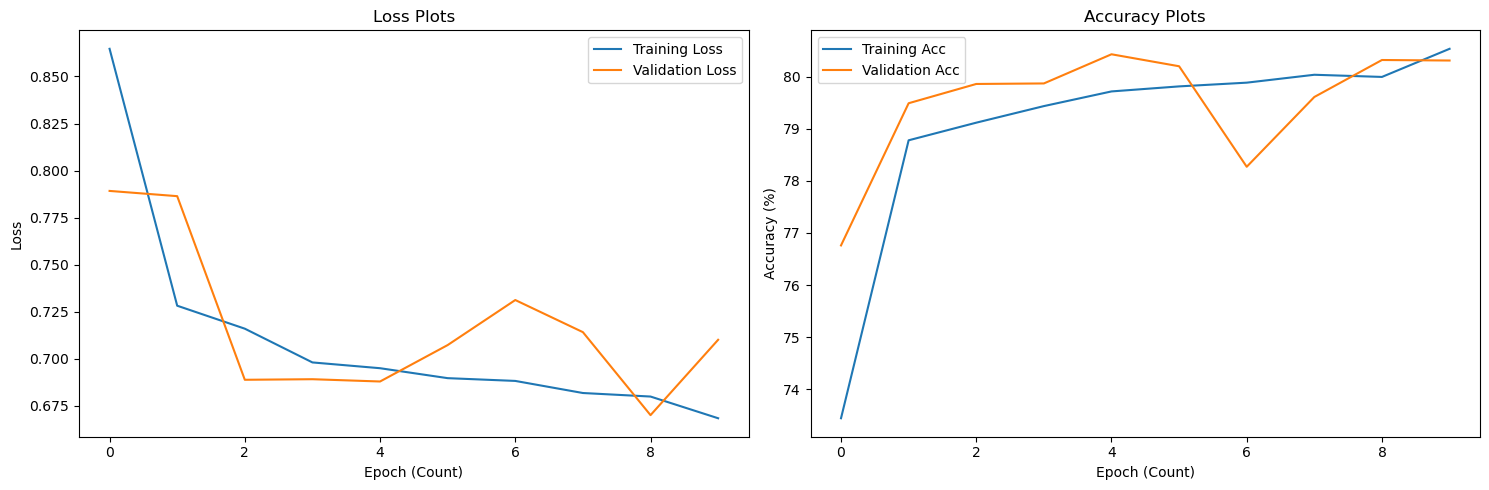

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_loss_history, label='Training Loss')
axs[0].plot(test_loss_history, label='Validation Loss')
axs[0].set_title('Loss Plots')
axs[0].set_xlabel('Epoch (Count)')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(train_acc_history, label='Training Acc')
axs[1].plot(test_acc_history, label='Validation Acc')
axs[1].set_title('Accuracy Plots')
axs[1].set_xlabel('Epoch (Count)')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
plt.tight_layout()

Using higher learning rate of 0.01 appears to be making the model stuck in a local minima and cannot improve further. Thus, we stick with the first model instead.

## Saving your model
Using `torch.save`, save your model for future loading.

In [137]:
torch.save(model.state_dict(), './model.pth')